# CLARITY DRYP WINTER SCHOOL, UK: FEB 10 TO MAR 21 2025

## Hydrological modelling using DRYP

This comprehensive school affords us the opportunity to build the DRYP models of the CLARITY TLabs.

The following contents will be covered:

* 1. Installation of the DRYP model (all participants have done this ahead of the Winter School).
* 2. ***Preparing model input parameters and dataset***
* 3. Preparing and running DRYP simulations
* 4. Post processing simulation outputs


### 2. Preprocessing model inputs

This section explores how model inputs (parameters and datasets) required for runing DRYP models can be created. 

The section presents simple raster operations to store and save variables (scripts can be accessed at https://github.com/AndresQuichimbo/DRYPv2.0.1.git.).

More complex operations can be performed using any GIS software (e.g ArcMap, QGis) or relevant python libraries such as rasterio.

It is important to note that the preprocessing (also postprocessing) module is under developement therefore the list of functions available are still limited. All available functions can be found in the following link: https://github.com/AndresQuichimbo/DRYPv2.0.1.git.

For the CLARITY Winter School, the domains for the Dodoma TLab, Maradi-Katsina TLab, and Raichur TLab have been delineated. 

However, note that DRYP preprocessing module can be used to delineate new basins. You can explore the link above on how new subbasins can be delineated using appropriate DRYP tools. 

Meanwhile, raw geospatial data can be found in different repositories such as Hydrosheds, SoilGrids, etc.

For the Winter School,  the following steps will be carried out in order to produce the set of model parameters for each of the CLARITY TLab.

* A. Clip extent of model parameters to reduce simulation times (fit to the model domains)
* B. Create a flow direction map compatible with DRYP-landlab format
* C. Create a river network
* D. Create AWC, field capacity, and wilting point soil parameters
* E. Create channel decay parameter
* F. Create a constant head boundary condition from water table depth
* G. Use of GIS softwares in building model parameters
* H. Other pre-processing steps using python libraries as are relevant.


In [1]:
# Import the following libraries/tools from your repository

import sys

sys.path.append("C:/Users/oshin/OneDrive - Cardiff University/CLARITY/DRYP")  # CHANGE THIS TO YOUR MODEL PATH

import cuwalid.dryp.components.DRYP_watershed as ppbasin
import cuwalid.tools.DRYP_pptools as pptools
import cuwalid.tools.DRYP_rrtools as rrtools

**NOTE**: For more private studies, you may download and unzip all files required for this training by cliking in the following link: 
https://drive.google.com/drive/folders/1Lf9fdOjjZO87sU1PCsUbKTNjt5IXr9DD?usp=drive_link

**WARNING**: Always ensure you put the correct paths of your files.

#### Introductory Task: Visualising parameters

First, specify path of parameter files that will be visualised.

In [10]:
######
general_path = "C:/Users/oshin/OneDrive - Cardiff University/CLARITY/Work_India/model/"  # CHANGE THIS TO YOUR MODEL PATH
basin_path = general_path + "parameters/"
######

In [11]:
#####
fname_surface = basin_path + "DEM_raichur_tlab_utm.asc"
fname_flowdir = basin_path + "raichur_tlab_flowdir_landlab.asc"
fname_outlet = basin_path + "raichur_tlab_domain_outlets_utm.csv"

**TASK**: Raster datasets can be visualised by using the following function to quickly create the maps.

In [12]:
import matplotlib.pyplot as plt
import rasterio
# this function can be used for ploting raster maps, modify it as your conveniency.
def plot_raster_file(fname, ax=None, vmin=-20.0, vmax=20.0):
    # create plot
    if ax is None:
        fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap('coolwarm_r', 12)
    data = rasterio.open(fname).read(1)
    im = ax.imshow(data,# origin="lower",#cmap=cmap, 
                   #vmin=vmin, vmax=vmax,
                   )#extent=bounds)	
    
    ax.axis('off')
    plt.colorbar(im)
    return im

C:\Users\oshin\AppData\Local\Temp\ipykernel_19784\4105126583.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


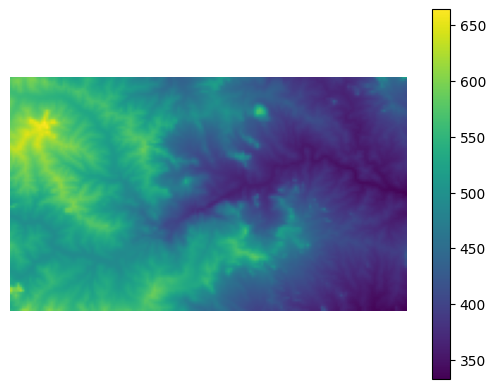

In [13]:
plot_raster_file(fname_surface)

C:\Users\oshin\AppData\Local\Temp\ipykernel_19784\4105126583.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


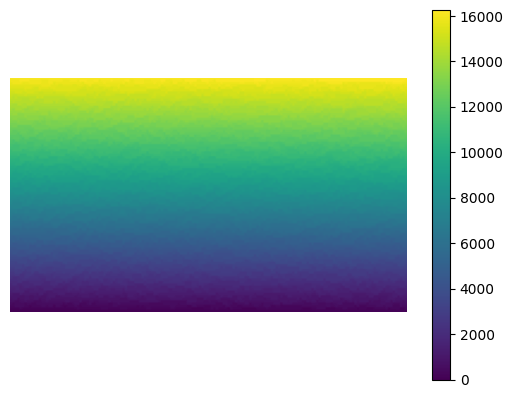

In [14]:
plot_raster_file(fname_flowdir)

**TASK** Read the csv files of the domain outlets and observation stations to depict these points in the domain. See examples below done without reading the csv files.

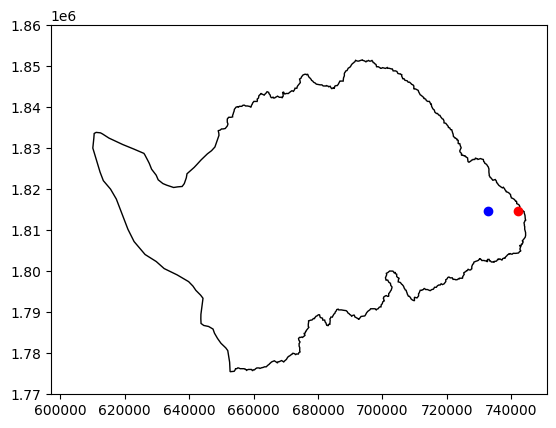

In [30]:
### First, plot the TLab domain ###
import shapefile as shp

fname_shp = basin_path + "raichur_tlab_domain.shp"

boundary = shp.Reader(fname_shp)
ap_bnd = boundary.shapes()
points = ap_bnd[0].points
#print(ap_bnd)
#print(points)
###
#fig = plt.figure(figsize=(6.5, 4.5))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim([597000, 751000])  
plt.ylim([1770000, 1860000])
ap = plt.Polygon(points, fill=False, edgecolor="k")
ax.add_patch(ap)
plt.scatter(732909,1814638, c='b')
plt.scatter(741980,1814638, c='r')

#### A. Clip extent of model parameters

We start by showing how to create basin masks to reflect the region where the model calculates the expected output variables.

After, we show how to extract parameters for a domain from dataset maps covering larger extents. This actions can also be done using GIS softwares.

A(1). Create a mask file for the domain: This function takes a shapefile (*.shp) and a raster file (*.asc) to create a new raster containing the shapefile geometry as mask.

In [34]:
## For Example:
"""
fname_output = basin_path + "raichur_tlab_domain_mask_created.asc"
#####
rrtools.create_raster_from_shapefile(fname_shp, fname_surface, fname_output)
"""

'\nfname_output = basin_path + "raichur_tlab_domain_mask_created.asc"\n#####\nrrtools.create_raster_from_shapefile(fname_shp, fname_surface, fname_output)\n'

A(2). Clip parameters to fit to the extent of the surface file.

In [35]:
## For Example:
"""
fname_in = basin_path + "india_flowaccum.asc"
fmask = basin_path + "raichur_tlab_domain_mask_created.asc"
fname_out = basin_path + "raichur_tlab_domain_flowaccum.asc"

rrtools.clip_raster_by_mask(fname, fmask, fname_output)
"""

'\nfname_in = basin_path + "india_flowaccum.asc"\nfmask = basin_path + "raichur_tlab_domain_mask_created.asc"\nfname_out = basin_path + "raichur_tlab_domain_flowaccum.asc"\n\nrrtools.clip_raster_by_mask(fname, fmask, fname_output)\n'

**TASK**: Create all parameters files required for your TLab basin, make sure that all files have the same grid size.

**TASK**: Visualise the created parameters.

#### B. Create a flow direction map compatible with DRYP

DRYP uses a flow direction map based on the LandLab based notation (https://landlab.readthedocs.io/en/latest/reference/components/flow_director.html).

So, in order to use a flow direction map from any sources that are generally in D8 format (e.g. from Hydrosheds), such map has to be transformed
into LandLab format. 

The following function will help with this:

In [36]:
"""
fflowdird8 = basin_path + "XXXX_flowdir.asc"
fname_flowdir = basin_path + "XXXX_flowdir_landlab.asc"

rrtools.create_raster_flowdirection_dryp(fflowdird8, fname_flowdir)
"""

'\nfflowdird8 = basin_path + "XXXX_flowdir.asc"\nfname_flowdir = basin_path + "XXXX_flowdir_landlab.asc"\n\nrrtools.create_raster_flowdirection_dryp(fflowdird8, fname_flowdir)\n'

**TASK**: Visualize the created flow direction map

#### C. Create a river network

River networks can be created form flow accumulation maps. 
The river network can be created based on a minimum number of cells or the minimun area.

In [37]:
"""
fname_flowaccum = basin_path + "XXXX_flowaccum.asc"
threshold = 10
fname_output = basin_path + "XXXX_river_network.asc"

rrtools.create_raster_river_network(fname_flowaccum, threshold, fname_output, cell_area=False, fill_value=1400)
"""

'\nfname_flowaccum = basin_path + "XXXX_flowaccum.asc"\nthreshold = 10\nfname_output = basin_path + "XXXX_river_network.asc"\n\nrrtools.create_raster_river_network(fname_flowaccum, threshold, fname_output, cell_area=False, fill_value=1400)\n'

**TASK**: Change the threshold to see how the river network varies

**TASK**: Visualize the created river networks

#### D. Create AWC, wilting point and field capacity soil parameters

#### E. Create channel decay parameter

#### F. Create constant head boundary condition

Create a raster file of constant head BC from values at specified locations of a raster file. 
Only values at selected locations are kept in the raster, values at the remaining location are assined -9999 (non data values in DRYP).

This tool can also be used for creating a flux boundary condition.

In [39]:
## For Example:
"""
fname_wte = basin_path + "XXXX_wte_ini.asc"
fname_outlet = basin_path + "XXXX_CHB_stations.csv"
fname_output = basin_path + "XXXX_CHB.asc"

rrtools.create_raster_bc_at_point(fname_wte, fname_outlet, fname_output)
"""

'\nfname_wte = basin_path + "XXXX_wte_ini.asc"\nfname_outlet = basin_path + "XXXX_CHB_stations.csv"\nfname_output = basin_path + "XXXX_CHB.asc"\n\nrrtools.create_raster_bc_at_point(fname_wte, fname_outlet, fname_output)\n'

**TASK**: Modify the list of points in the csv file to create a new file for head boundary conditions. Then, visualise the created files.

**G. Exploring the use of GIS software to create the model parameters**

**H. Other pre-processing tools**

We can use relevant python libraries to convert files from one format to another, for exploring some datasets, etc.

**I. Clip all raster parameters files for running the model**

In [40]:
##
"""
import glob

files = glob.glob(regional_path+"inputs/*.asc")
"""

'\nimport glob\n\nfiles = glob.glob(regional_path+"inputs/*.asc")\n'

In [41]:
"""
new_path = basin_path + "/raichur_tlab_domain_"
fnames = []
for ifile in files:
    #fnames.append(ifile.split("\\")[-1])
    new_name = new_path + ifile.split("\\")[-1]
    fnames.append(new_name)
    print(new_name)
    #new_name = new_path + fnames[0]
    #process clip raster
    #rrtools.clip_raster_by_mask(ifile, fmask, new_name)
"""

'\nnew_path = basin_path + "/raichur_tlab_domain_"\nfnames = []\nfor ifile in files:\n    #fnames.append(ifile.split("\\")[-1])\n    new_name = new_path + ifile.split("\\")[-1]\n    fnames.append(new_name)\n    print(new_name)\n    #new_name = new_path + fnames[0]\n    #process clip raster\n    #rrtools.clip_raster_by_mask(ifile, fmask, new_name)\n'

**J. Check that all raster datasets are correct**

In [42]:
#### fname_base needs to be updated
"""
fname_base = basin_path+"raichur_tlab_domain_wp.asc"
for ifname in fnames:
    rrtools.check_raster_alignaments(fname_base, ifname)
"""

'\nfname_base = basin_path+"raichur_tlab_domain_wp.asc"\nfor ifname in fnames:\n    rrtools.check_raster_alignaments(fname_base, ifname)\n'